# TD 9 - Algorithme Variationel et Modèle de Heisenberg

Nous considérons deux spins $\frac{1}{2}$ en interaction avec une constante d'échange $J > 0$. 
Pour représenter ce système, nous considérons un espace de Hilbert $\mathcal H = \mathbb{CP}_1\otimes \mathbb{CP}_1$ avec $\mathbb{CP}_1$ la sphere de Bloch.
Le Hamiltonien correspondant est:
$$ H = J\vec{\sigma}_1\cdot \vec{\sigma}_2 = J\sigma^X_1 \sigma^X_2 + J\sigma^Y_1 \sigma^Y_2 + J\sigma^Z_1 \sigma^Z_2 $$
avec $\sigma_\cdot$ les matrices de Pauli.
Nous avons par définition de l'état fondamental $|{\phi_{GS}}\rangle$, que:
$$\forall |\psi\rangle \in \mathcal H, \qquad \langle \psi|H|\psi\rangle \geq \langle{\phi_{GS}}|H|{\phi_{GS}}\rangle $$

Ainsi, afin de trouver l'état fondamental de ce système, nous utilisons la méthode variationelle qui consiste à minimiser une energie sur un ensemble d'états paramétriques $$X=\left\{|\psi_\theta\rangle\in \mathbb C^N\text{ such that }\|\psi_\theta\|_2=1 | \theta \in \Theta \right\},$$ avec $\theta$ le vecteur des paramètres et $\Theta$ l'ensemble des paramètres valides, par exemple pour un ansatz avec une unique porte RY appliqué au premier qubit, nous aurions $X=\left\{R_Y(\theta)|0\rangle\,|\theta \in \Theta\right\}$ avec $\Theta=\mathbb R$.

Nous cherchons la solution du problème de minimisation $$\theta^*=\underset{\theta\in\Theta}{\mathrm{argmin}}\, \langle \psi_\theta|H|\psi_\theta\rangle.$$
Si la famille $X$ est bien choisie, nous avons l'égalité 
$$|\psi_{\theta^*}\rangle=|\phi_{GS}\rangle$$


## Exercice 1.(Sur papier)

Soit $J=1$, considérons l'ansatz définie par:
$$|\psi_\theta\rangle = \left(\sin\frac{\alpha}{2} |0\rangle + \cos\frac{\alpha}{2}|1\rangle\right)\otimes\left(\sin\frac{\beta}{2} |0\rangle + \cos\frac{\beta}{2}|1\rangle\right)$$
avec $\theta=(\alpha,\beta) \in \mathbb R^2$

__a) Calculer__ $E(\theta)=\langle\psi_\theta|H|\psi_\theta\rangle$

__b) Calculer le gradient de__ $E(\theta)$

__c) Trouver__ $\theta^*=\underset{\theta\in\Theta}{\mathrm{argmin}}\,E(\theta)$

__d) L'état trouvé est-il l'état fondamental? Justifiez.__

# Installation - Google Colab only

Nous allons maintenant procéder à l'installation de myQLM, un outil de simulation de circuits quantique.

In [ ]:
!pip install myqlm

In [ ]:
!python -m qat.magics.install

Relancer le runtime en cliquant sur le menu "Runtine" et sur l'option "Restart Runtime"

## Exercice 2
Le code suivant construit un circuit simple qui nous servira d'ansatz:

In [1]:
from qat.core import Observable, Term
from qat.lang.AQASM import Program, CNOT, H, RX, RY, RZ

# Nous créeons une instance de la classe Program, qui permets de construire des circuits quantique en allocant des qubits puis en agissant dessus avec des portes
prog = Program()
# Fonction d'allocation de qubits, qalloc(2) alloue 2 qubits au program, indexé à partir de 0
qbits = prog.qalloc(2)
# Instantiation de variables, new_var(float,"name") crée une nouvelle variable de type float ayant pour nom: name
alpha = prog.new_var(float, "\\alpha")
beta = prog.new_var(float, "\\beta")
# Application de Porte, apply(gate,index_list) applique la porte gate aux qubits indexé par index_list
prog.apply(RY(alpha), qbits[0])
# Construction d'un circuit à partir du program
tensor_product_circuit = prog.to_circ()

%qatdisplay tensor_product_circuit --svg

__a) Appliquer une RY au second qubit dans le code ci-dessus. Vérifiez le circuit en sortie.__

Nous allons maintenant utiliser l'ansatz ci-dessus pour trouvez les paramètres minimisant l'énergie de l'exercice 1

Nous construisons d'abord l'observable associée à $H$ pour $J=1$.
Pour cela, nous utilisons les classes Observable et Term de myQLM:

Observable(N_qubits, pauli_terms) construit une observable à N_qubits qubits ayant pour termes de Paulis pauli_terms.

Les termes de Pauli sont défini par une chaine de caractère de la forme "PQR"et une liste de nombre [k,n,m] encodant le terme de Pauli ainsi $\text{Term(1.,"PQR",[k,n,m])}=\sigma^P_k\cdot\sigma^P_n\cdot\sigma^R_m$

In [2]:
J=1
H_XYZ = Observable(2, 
                  pauli_terms=[Term(1., "XX", [0, 1]),
                               Term(1., "YY", [0, 1]),
                               Term(1., "ZZ", [0, 1])]
                  )
# Nous multiplions le Hamiltonien par le coefficient global J
H_S = J*H_XYZ

Nous utilisons maintenant un optimiseur de la librairie de calcul scientifique scipy pour minimiser notre énergie.

Nous choisissons notre ansatz:

In [3]:
ansatz_circuit = tensor_product_circuit

# Paramètres initiaux
theta0 = [0.5,0.4]


Minimum energy = -0.9999993392598658
Optimal angles = [3.1404430969736494, 0.24566601055872356]


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


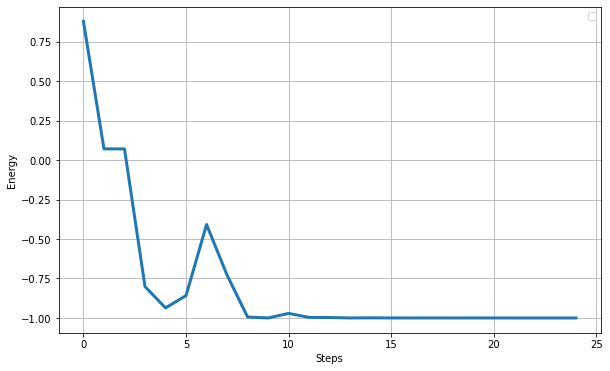

In [4]:
from qat.plugins import ScipyMinimizePlugin
from qat.pylinalg import PyLinalg


linalg_qpu = PyLinalg()

optimizer_scipy = ScipyMinimizePlugin(method="COBYLA",
                                      x0=theta0,
                                      tol=1e-3,
                                      options={"maxiter": 2000})

qpu = optimizer_scipy | linalg_qpu

job = ansatz_circuit.to_job(job_type="OBS", observable=H_S)

result = qpu.submit(job)

print("Minimum energy =", result.value)
print("Optimal angles =", result.meta_data["parameters"])
#print("==========Optimization data=============\n", result.meta_data['optimization_trace'])

%matplotlib inline
import matplotlib.pyplot as plt
plt.figure(figsize=(1.618*6,6))
plt.plot(eval(result.meta_data['optimization_trace']),lw=3)
plt.xlabel("Steps")
plt.ylabel("Energy")
plt.grid()
plt.legend()

Par ailleurs, nous pouvons trouver l'énergie fondamentale par une diagonalisation de la matrice $H$

In [5]:
import numpy as np
# Définissons les matrices de Pauli
s_I=np.eye(2)
s_X=np.asarray([[0,1],[1,0]])
s_Y=np.asarray([[0,-1j],[1j,0]])
s_Z=np.asarray([[1,0],[0,-1]])

# Nous construisons la matrice associée au Hamiltonien
H_XYZ_matrix = (np.kron(s_X,s_X) + np.kron(s_Y,s_Y) + np.kron(s_Z,s_Z))

H_matrix = J*H_XYZ_matrix
# Nous diagonalisons la matrice
eigvals, eigvecs = np.linalg.eigh(H_matrix)
print("Exact ground state energy: ", min(eigvals))
print(f"Ground state: {eigvecs[:,0]}")

Exact ground state energy:  -3.0
Ground state: [ 0.        +0.j  0.70710678+0.j -0.70710678+0.j  0.        +0.j]


Nous n'obtenons pas l'énergie fondamentale à travers la minimisation, l'ansatz semble donc mal adapté pour ce Hamiltonien.

__b) A quoi correspond l'état fondamental? Pourquoi n'atteint-on pas cet état avec notre ansatz tensor_product_ansatz? Justifiez.__

Nous construisons maintenant un autre ansatz GS_ansatz_circuit qui aura pour but de repliqué l'état fondamental:

In [13]:
from qat.core import Observable, Term
from qat.lang.AQASM import Program, CNOT, H, RX, RY, RZ

prog = Program()
qbits = prog.qalloc(2)
alpha = prog.new_var(float, "\\alpha")
beta = prog.new_var(float, "\\beta")
gamma = prog.new_var(float, "\\gamma")

## REMOVE IN FINAL VERSION
prog.apply(H,qbits[0])
prog.apply(RY(alpha), qbits[1])
prog.apply(CNOT, qbits)
prog.apply(RX(beta), qbits[0])
prog.apply(RY(gamma), qbits[1])
##

GS_ansatz_circuit = prog.to_circ()

%qatdisplay GS_ansatz_circuit --svg


__c) Modifier GS_ansatz_circuit afin de pouvoir construire l'état fondamental.__

__d) Remplacer l'ansatz utilisé dans le calcul varationnel par GS_ansatz_circuit et relancer le calcul, converge-t-on vers l'énergie fondamentale?__

__e) Répéter le calcul pour $J=-1$ pour chacun des ansatz, que pouvez vous en déduire sur le modèle de Heisenberg?__

## Exercice 3 - Transition de Phase
Nous ajoutons maintenant au Hamiltonien un terme dû à un champ magnétique externe orienté selon l'axe Z.
$$ H = J\left(\sigma^X_1 \sigma^X_2 + \sigma^Y_1 \sigma^Y_2 + \sigma^Z_1 \sigma^Z_2\right) + h_B\left(\sigma^Z_1+ \sigma^Z_2\right)$$
avec $h_B\geq 0$

__a) Définir l'observable__ $H_Z=\sigma^Z_1+\sigma^Z_2$ 

In [14]:
H_Z = Observable(2,
                 pauli_terms = [Term(1,"Z",[0]),Term(1,"Z",[1]), ## REMOVE IN FINAL VERSION  
                 ])


In [8]:
H_Z_matrix = np.kron(s_Z,s_I) + np.kron(s_I,s_Z)

Nous définissons ici l'ansatz pour cet exercice:

In [9]:

#Paramètres initiaux
theta0 = [0.4, -0.3, 0.6]

# Circuit ansatz
prog = Program()
qbits = prog.qalloc(2)
alpha = prog.new_var(float, "\\alpha")
beta = prog.new_var(float, "\\beta")
gamma = prog.new_var(float, "\\gamma")

## REMOVE IN FINAL VERSION
prog.apply(H,qbits[0])
prog.apply(RY(alpha), qbits[1])
prog.apply(CNOT, qbits)
prog.apply(RX(beta), qbits[0])
prog.apply(RY(gamma), qbits[1])
##

ansatz_circuit = prog.to_circ()

Nous allons maintenant calculer le spectre du Hamiltonien ainsi que l'énergie minimum pour notre ansatz pour des valeurs de $J\in[-2, 2]$ avec $h_B$ fixé à 2.

In [10]:
results=[]
results_vec=[]
results_eigvals=[]
results_eigvecs=[]


J_values=np.linspace(-2,2,101)
h_B=2

for i,j in enumerate(J_values):

    H_tot=j * H_XYZ + h_B * H_Z
    
    optimizer_scipy = ScipyMinimizePlugin(method="COBYLA",
                                          x0=theta0,
                                          tol=1e-3,
                                          options={"maxiter": 20000})

    qpu = optimizer_scipy | linalg_qpu
    job = ansatz_circuit.to_job(job_type="OBS", observable=H_tot)
    
    result = qpu.submit(job)
    results.append(result.value)
    
    sol_vec=linalg_qpu.submit(ansatz_circuit.to_job()(**result.parameter_map)).statevector
    
    results_vec.append(sol_vec)
    H_tot_matrix = j * H_XYZ_matrix + h_B * H_Z_matrix

    eigvals, eigvecs = np.linalg.eigh(H_tot_matrix)
    results_eigvals.append(eigvals)
    results_eigvecs.append(eigvecs)
    if i % 20 == 0 :print(f"Step {i}, J={j} Minimum energy =", result.value)

Step 0, J=-2.0 Minimum energy = -2.999999490560471
Step 20, J=-1.2 Minimum energy = -2.4499983185124674
Step 40, J=-0.3999999999999999 Minimum energy = -2.066654700207853
Step 60, J=0.3999999999999999 Minimum energy = -2.099986190634146
Step 80, J=1.2000000000000002 Minimum energy = -3.599997117166421
Step 100, J=2.0 Minimum energy = -5.999998730384595


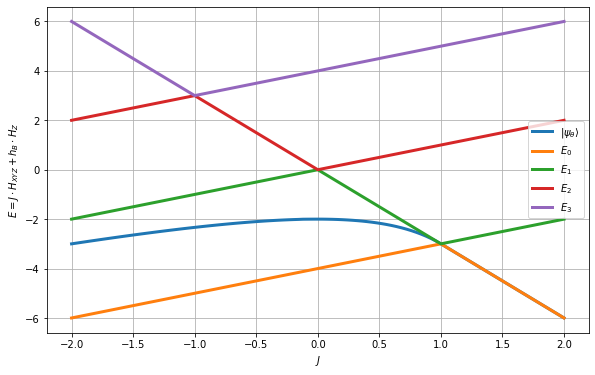

In [11]:
plt.figure(figsize=(1.618*6,6))
plt.plot(J_values,results,lw=3,label=r"$|\psi_\theta\rangle$")
for k,E in enumerate(np.asarray(results_eigvals).transpose()):
    plt.plot(J_values,E,lw=3,label=f"$E_{k}$")
plt.ylabel(r"$E=J\cdot H_{XYZ}+h_B\cdot H_Z$")
plt.xlabel("$J$")
plt.legend()
plt.grid()

__a) Que pouvez vous dire sur l'état fondamental du système? pour différentes valeurs de $J$?__

__b) A quoi correspondent les croisements des courbes?__

__c) L'ansatz est-il adapté à toutes les valeurs de $J$?__

__d) Modifier l'ansatz afin de trouver l'état fondamental du système pour toute valeurs de $J$.__

__e) Changer la valeur de $h_B\in[-2,2]$, quel est l'effet de $h_B$ sur les valeurs propres?__
